# FewLearn Basic Example

This notebook demonstrates how to:
1. Initialize the MINDS framework
2. Add different backbone models
3. Evaluate them in parallel on the Omniglot dataset
4. Visualize and compare results

First, let's import the required packages:

In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import Omniglot
from torchvision import transforms
import os
from tabulate import tabulate
import pandas as pd

from fewlearn import MINDS, PrototypicalNetworks, EpisodicProtocol, Evaluator
from fewlearn.visualization import plot_performance_comparison, plot_prototype_embeddings

# Set random seed for reproducibility
torch.manual_seed(42)

## 1. Initialize MINDS Framework

First, we'll create an instance of the MINDS framework:

In [2]:
minds = MINDS()
print("[OK] MINDS framework initialized")

Using GPU: NVIDIA GeForce GTX 1050
MINDS framework initialized successfully on cuda
[OK] MINDS framework initialized


## 2. Add Backbone Models

We'll add three different backbone models to evaluate:

In [3]:
# Add different backbone models
backbones = ["resnet18", "mobilenet_v2", "efficientnet_b0"]

for backbone in backbones:
    minds.add_model(backbone, PrototypicalNetworks(backbone=backbone))
    print(f"[OK] Added {backbone} model")

Added model 'resnet18' successfully on cuda
[OK] Added resnet18 model
Added model 'mobilenet_v2' successfully on cuda
[OK] Added mobilenet_v2 model
Added model 'efficientnet_b0' successfully on cuda
[OK] Added efficientnet_b0 model


## 3. Prepare Dataset

We'll use the Omniglot dataset, which is commonly used for few-shot learning:

In [4]:
# Create data directory
os.makedirs('./data', exist_ok=True)

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((84, 84)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Load Omniglot dataset
dataset = Omniglot(root='./data', download=True, transform=transform)
print(f"[OK] Loaded Omniglot dataset with {len(dataset)} images")

Files already downloaded and verified
[OK] Loaded Omniglot dataset with 19280 images


## 4. Setup Evaluation Protocol

We'll create a 5-way 1-shot evaluation protocol with 15 query samples per class:

In [5]:
# Create evaluation protocol
protocol = EpisodicProtocol(
    n_way=5,      # Number of classes per episode
    n_shot=5,     # Number of support samples per class
    n_query=10,   # Number of query samples per class
    episodes=100   # Number of episodes to evaluate
)

# Create evaluator
evaluator = Evaluator(
    protocol=protocol,
    metrics=["accuracy", "f1"],
    parallel=True  # Enable parallel evaluation
)

print("[OK] Created evaluation protocol and evaluator")

[OK] Created evaluation protocol and evaluator


## 5. Run Evaluation

Now let's evaluate all models in parallel:

In [6]:
from IPython.display import clear_output

def progress_callback(progress):
    clear_output(wait=True)
    print(f"Evaluation progress: {progress:.1%}")

results = evaluator.evaluate(
    models=minds.models,
    dataset=dataset,
    progress_callback=progress_callback
)

print("[OK] Evaluation complete!")

Evaluation progress: 100.0%
[OK] Evaluation complete!


## 6. Results Summary

Let's display the results in a nicely formatted table:

In [7]:
# Get results summary
summary = evaluator.summary()

# Convert summary to pandas DataFrame for better formatting
df = pd.DataFrame(summary)

# Format metrics to 3 decimal places
df = df.round(3)

# Display table using tabulate with modern formatting
print(tabulate(
    df, 
    headers='keys',
    tablefmt='fancy_grid',
    showindex=False
))

# Get best model
best_model_name, best_model = minds.get_best_model(results)
print(f"[BEST] Best performing model: {best_model_name}")

╒════════════╤═══════╤═════════════════╤════════════════╤════════════════╤════════════════╤═══════════╤══════════╤══════════╤══════════╤═══════════════════╕
│   accuracy │    f1 │   accuracy_mean │   accuracy_std │   accuracy_min │   accuracy_max │   f1_mean │   f1_std │   f1_min │   f1_max │   evaluation_time │
╞════════════╪═══════╪═════════════════╪════════════════╪════════════════╪════════════════╪═══════════╪══════════╪══════════╪══════════╪═══════════════════╡
│      0.925 │ 0.925 │           0.925 │          0.054 │           0.76 │              1 │     0.925 │    0.054 │    0.765 │        1 │             77.54 │
├────────────┼───────┼─────────────────┼────────────────┼────────────────┼────────────────┼───────────┼──────────┼──────────┼──────────┼───────────────────┤
│      0.933 │ 0.933 │           0.933 │          0.046 │           0.76 │              1 │     0.933 │    0.047 │    0.758 │        1 │             77.54 │
├────────────┼───────┼─────────────────┼────────────────┼─

## 7. Visualizations

Let's create some visualizations to better understand the results:

Creating performance comparison visualization...


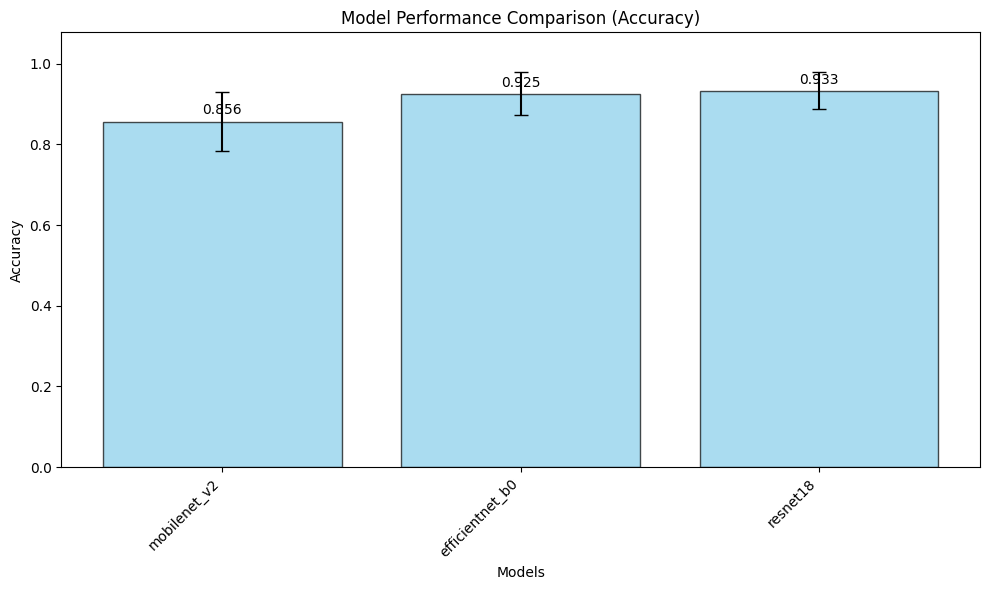

In [8]:
#Create a visualization folder
os.makedirs('./visualizations', exist_ok=True)

#Plot model performance comparison
print("Creating performance comparison visualization...")
fig = plot_performance_comparison(results)
fig.savefig("./visualizations/model_comparison.png")

## 8. Export Best Model

Finally, let's export the best performing model for deployment:

In [9]:
export_path = minds.export_model(best_model_name, format="pt")
print(f"[OK] Best model exported to: {export_path}")

Model exported to PyTorch format at: resnet18.pt
[OK] Best model exported to: resnet18.pt
